### Importing modules

In [103]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import opendatasets as od
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import cv2

### Downloading the dataset

In [42]:
dataset_url = "https://www.kaggle.com/datasets/andrewmvd/animal-faces"
od.download(dataset_url)

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [43]:
# Getting the class names
data_dir = "./animal-faces/afhq"
classes = os.listdir(data_dir + "/train")
print(classes)

['wild', 'cat', 'dog']


In [44]:
# Loading the image and converting them to tensors
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
dataset = ImageFolder(data_dir + "/train", transform=transform)

In [45]:
# Function to show the image
def show_image(img):
    plt.imshow(img.permute(1, 2, 0))


### Creating a Training and Validation Dataset

In [46]:
from torch.utils.data import random_split

random_seed = 42
torch.manual_seed(random_seed)

val_size = 1500
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [47]:
# Converting image dataset to dataloader
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size*2)

In [48]:
# Function to show a batch of images
from torchvision.utils import make_grid
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

## Model 1 - Convulation Neural Network Model

In [49]:
class CNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        # 3 X 32 X 32
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # 32 X 32 X 32
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # 64 X 32 X 32
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # 64 X 16 X 16

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # 128 X 16 X 16
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), # 128 X 16 X 16
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # 128 X 8 X 8

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # 256 X 8 X 8
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1), # 256 X 8 X 8
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # 256 X 4 X 4

        nn.Flatten(),
        nn.Linear(256*4*4, 1024), # 1024
        nn.ReLU(),
        nn.Linear(1024, 512), # 512
        nn.ReLU(),
        nn.Linear(512, 3) # 3
    )

  def forward(self, xb):
    return self.network(xb)

### Loading the data on GPU device

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [51]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
model = to_device(CNNModel(), device)

### Training the Model

In [52]:
# Check the accuracy of model
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Train the model
def fit(epochs, lr, model, train_loader, val_loader, opt_func):
  output = {
      'train_loss': [],
      'val_loss': [],
      'val_acc': []
  }
  # Setting up the loss function
  loss_func = nn.CrossEntropyLoss()

  # Setting up the optimizer
  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):
    # Training step
    model.train()
    train_losses = []
    for xb, yb in train_loader:
      loss = loss_func(model(xb), yb)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      train_losses.append(loss.item())

    # Validation step
    model.eval()
    with torch.no_grad():
      val_losses = []
      val_accs = []
      for xb, yb in val_loader:
        loss = loss_func(model(xb), yb)
        val_losses.append(loss.item())
        acc = accuracy(model(xb), yb)
        val_accs.append(acc)

    # Printing the progress
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    val_acc = np.mean(val_accs)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    output['train_loss'].append(train_loss)
    output['val_loss'].append(val_loss)
    output['val_acc'].append(val_acc)

  return output

In [53]:
torch.manual_seed(42)
num_epochs = 5 # Number of epochs
opt_func = torch.optim.Adam # Optimizer
lr = 0.001 # Learning rate
output = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch 1/5, Train Loss: 0.7952, Val Loss: 0.4792, Val Acc: 0.7997
Epoch 2/5, Train Loss: 0.3584, Val Loss: 0.2852, Val Acc: 0.8899
Epoch 3/5, Train Loss: 0.2036, Val Loss: 0.1689, Val Acc: 0.9378
Epoch 4/5, Train Loss: 0.1364, Val Loss: 0.2103, Val Acc: 0.9300
Epoch 5/5, Train Loss: 0.1000, Val Loss: 0.1216, Val Acc: 0.9556


In [80]:
# Plotting Accuracy
def plot_accuracies(output):
    accuracies = output['val_acc']
    accuracies = [x*100 for x in accuracies]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs No of Epochs')

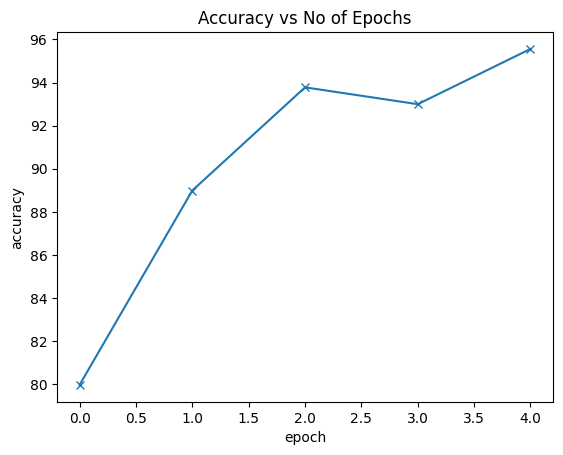

In [81]:
plot_accuracies(output)

In [56]:
# Plotting losses
def plot_losses(output):
    train_loss = output['train_loss']
    val_loss = output['val_loss']
    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Losses')
    plt.legend(['Training loss', 'Validation Loss'])
    plt.title('Losses vs No of Epochs')

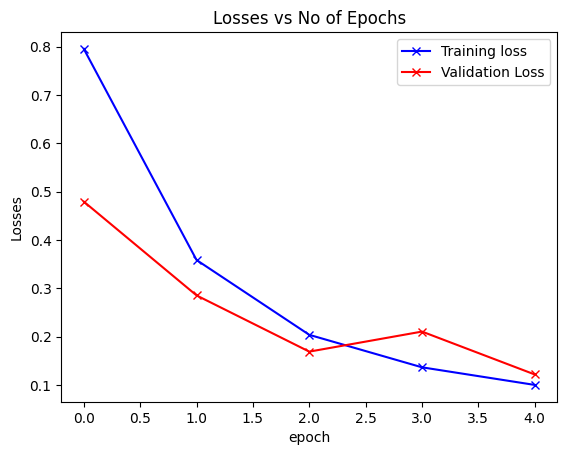

In [57]:
plot_losses(output)

## Model 2 - Residual Networks


In [69]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = conv_block(3, 32) # 32 X 32 X 32
    self.conv2 = conv_block(32, 64, pool=True) # 64 X 16 X 16
    self.res1 = nn.Sequential(
        conv_block(64, 64),
        conv_block(64, 64) # 64 X 16 X 16
    )
    self.conv3 = conv_block(64, 128, pool = True) # 128 X 8 X 8
    self.conv4 = conv_block(128, 256, pool = True) # 256 X 4 X 4
    self.res2 = nn.Sequential(
        conv_block(256, 256),
        conv_block(256, 256)
    ) # 256 X 4 X 4
    self.classifier = nn.Sequential(
        nn.MaxPool2d(4), # 256
        nn.Flatten(), # 256
        nn.Dropout(0.1),
        nn.Linear(256, 3) # 3 - output classes
    )

  def forward(self, X):
    out = self.conv1(X)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

In [70]:
model2 = to_device(ResNet(), device)

### Training the Model

In [71]:
def fit_RN(epochs, max_lr, model, train_loader, val_loader, opt_func):
  output = {
      'train_loss': [],
      'val_loss': [],
      'val_acc': []
  }
  # Setting up the loss function
  loss_func = nn.CrossEntropyLoss()

  # Setting up the optimizer
  optimizer = opt_func(model.parameters(), max_lr)

  # Setting up one-cycle learning rate scheduler
  sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
    # Training step
    model.train()
    train_losses = []
    for xb, yb in train_loader:
      loss = loss_func(model(xb), yb)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      train_losses.append(loss.item())

      # Update learning rate
      sched.step()

    # Validation step
    model.eval()
    with torch.no_grad():
      val_losses = []
      val_accs = []
      for xb, yb in val_loader:
        loss = loss_func(model(xb), yb)
        val_losses.append(loss.item())
        acc = accuracy(model(xb), yb)
        val_accs.append(acc)

    # Printing the progress
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    val_acc = np.mean(val_accs)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    output['train_loss'].append(train_loss)
    output['val_loss'].append(val_loss)
    output['val_acc'].append(val_acc)

  return output


In [72]:
torch.manual_seed(42)
num_epochs = 5 # Number of epochs
opt_func = torch.optim.Adam # Optimizer
lr = 0.001 # Learning rate
output_model2 = fit_RN(num_epochs, lr, model2, train_loader, val_loader, opt_func)

Epoch 1/5, Train Loss: 0.5425, Val Loss: 0.5004, Val Acc: 0.8377
Epoch 2/5, Train Loss: 0.1735, Val Loss: 0.1571, Val Acc: 0.9391
Epoch 3/5, Train Loss: 0.0614, Val Loss: 0.0872, Val Acc: 0.9654
Epoch 4/5, Train Loss: 0.0257, Val Loss: 0.0682, Val Acc: 0.9763
Epoch 5/5, Train Loss: 0.0051, Val Loss: 0.0675, Val Acc: 0.9761


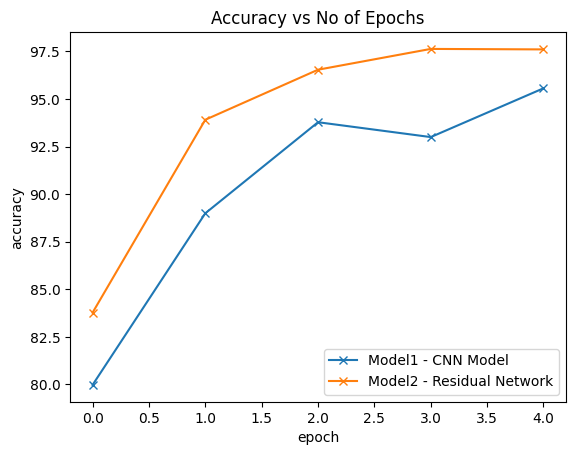

In [82]:
plot_accuracies(output)
plot_accuracies(output_model2)
plt.legend(['Model1 - CNN Model', 'Model2 - Residual Network'])

## Predicting on Random Data with Model 2

In [114]:
test_dataset = ImageFolder(data_dir + "/val", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size*2)
test_loader = DeviceDataLoader(test_loader, device)
img_dataset = ImageFolder(data_dir+'/val', transform=transforms.ToTensor())

In [92]:
def test_accuracy(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [93]:
test_acc_model1 = test_accuracy(model, test_loader, device)
test_acc_model2 = test_accuracy(model2, test_loader, device)

In [98]:
print(f"Test accuracy for model 1 :  {test_acc_model1:.2f} %")
print(f"Test accuracy for model 2 :  {test_acc_model2:.2f} %")

Test accuracy for model 1 :  95.73 %
Test accuracy for model 2 :  97.80 %


In [99]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return test_dataset.classes[preds[0].item()]

Actual :  cat , Predicted :  cat


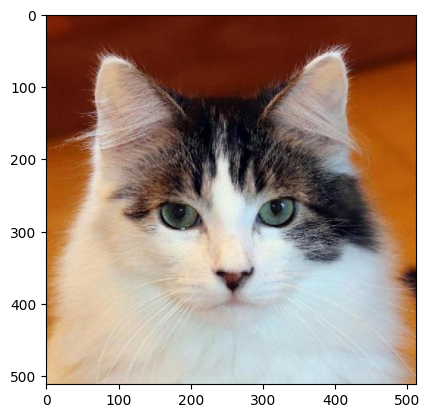

In [115]:
img, label = test_dataset[0]
orig_img,_ = img_dataset[0]
print('Actual : ', test_dataset.classes[label], ', Predicted : ', predict_image(img, model2))
plt.imshow(orig_img.permute(1,2,0))

Actual :  cat , Predicted :  cat


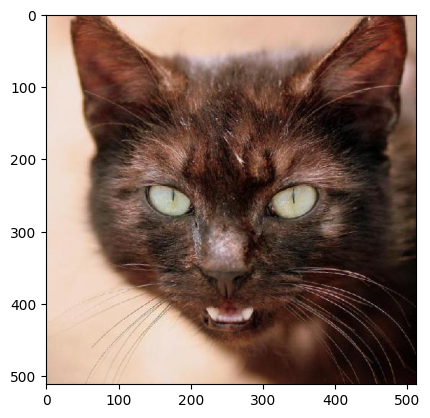

In [123]:
img, label = test_dataset[123]
orig_img,_ = img_dataset[123]
print('Actual : ', test_dataset.classes[label], ', Predicted : ', predict_image(img, model2))
plt.imshow(orig_img.permute(1,2,0))

Actual :  dog , Predicted :  dog


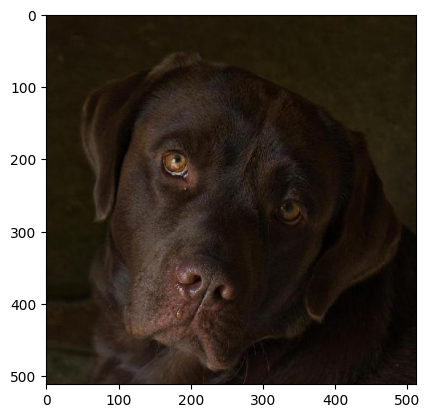

In [125]:
img, label = test_dataset[765]
orig_img,_ = img_dataset[765]
print('Actual : ', test_dataset.classes[label], ', Predicted : ', predict_image(img, model2))
plt.imshow(orig_img.permute(1,2,0))

Actual :  dog , Predicted :  dog


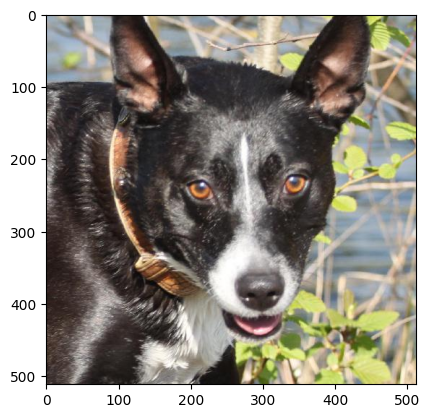

In [127]:
img, label = test_dataset[999]
orig_img,_ = img_dataset[999]
print('Actual : ', test_dataset.classes[label], ', Predicted : ', predict_image(img, model2))
plt.imshow(orig_img.permute(1,2,0))

Actual :  wild , Predicted :  wild


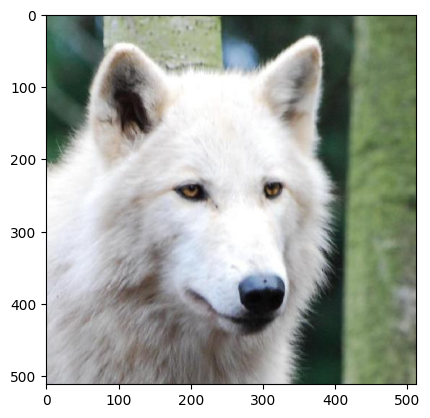

In [128]:
img, label = test_dataset[1342]
orig_img,_ = img_dataset[1342]
print('Actual : ', test_dataset.classes[label], ', Predicted : ', predict_image(img, model2))
plt.imshow(orig_img.permute(1,2,0))

Actual :  wild , Predicted :  wild


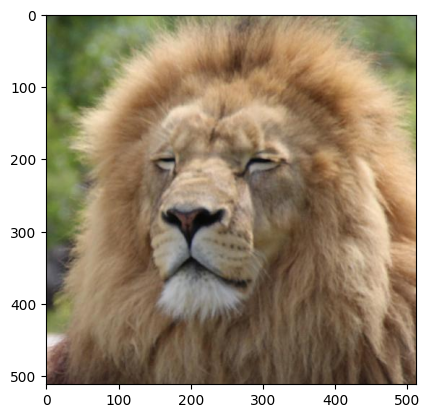

In [130]:
img, label = test_dataset[1499]
orig_img,_ = img_dataset[1499]
print('Actual : ', test_dataset.classes[label], ', Predicted : ', predict_image(img, model2))
plt.imshow(orig_img.permute(1,2,0))

Actual :  wild , Predicted :  wild


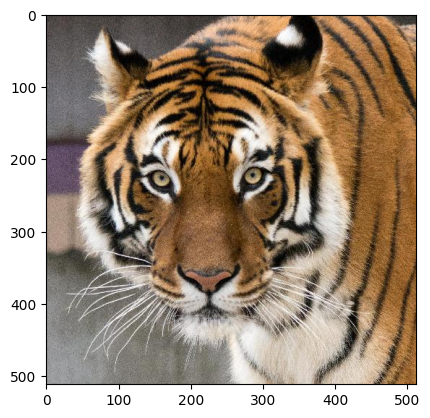

In [131]:
img, label = test_dataset[1200]
orig_img,_ = img_dataset[1200]
print('Actual : ', test_dataset.classes[label], ', Predicted : ', predict_image(img, model2))
plt.imshow(orig_img.permute(1,2,0))

Actual :  cat , Predicted :  cat


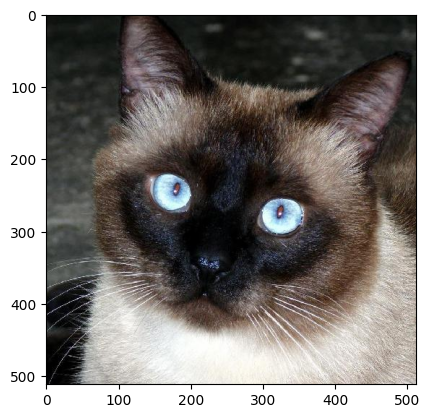

In [132]:
img, label = test_dataset[245]
orig_img,_ = img_dataset[245]
print('Actual : ', test_dataset.classes[label], ', Predicted : ', predict_image(img, model2))
plt.imshow(orig_img.permute(1,2,0))

Actual :  dog , Predicted :  dog


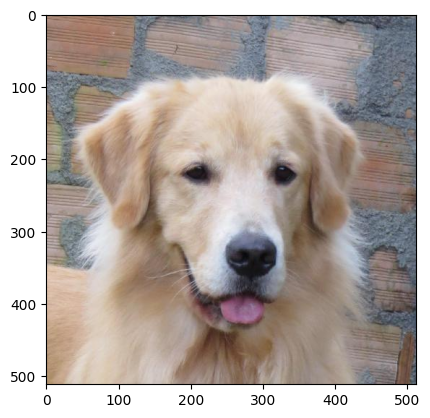

In [133]:
img, label = test_dataset[968]
orig_img,_ = img_dataset[968]
print('Actual : ', test_dataset.classes[label], ', Predicted : ', predict_image(img, model2))
plt.imshow(orig_img.permute(1,2,0))

**The model got an accuracy of 97.80%.**